In [2]:
import math
import torch
import numpy as np
import gpytorch
import pandas as pd
import seaborn as sns
import os
import pickle
import matplotlib 
matplotlib.use('Agg')
from matplotlib import pyplot as plt
import sklearn
from sklearn.model_selection import KFold

%matplotlib inline
# %load_ext autoreload
# %autoreload 2
%reload_ext autoreload
import imblearn as imb
# print("imblearn version: ",imblearn.__version__)
from imblearn.over_sampling import SMOTE

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import confusion_matrix
import itertools

from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, f1_score, roc_auc_score, roc_curve, precision_recall_curve, auc, recall_score

from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from rdkit import Chem
from rdkit.Chem import Draw
import sys
sys.path.append('../')
import utils
from sklearn.model_selection import GridSearchCV
from VisUtils import *
from split_data import *
from RF_GSCV import *
from RF_Utils import *


In [4]:
split_path = '../../../../data/NEK_data_4Berkeley/NEK2/'
original_trainX = pd.read_csv(split_path+"/NEK2_binding_random_fold1_trainX.csv")
original_trainy= pd.read_csv(split_path+"/NEK2_binding_random_fold1_trainY.csv")
original_testX= pd.read_csv(split_path+"/NEK2_binding_random_fold1_testX.csv")
original_testy= pd.read_csv(split_path+"/NEK2_binding_random_fold1_testY.csv")
# train_x = torch.from_numpy(train_x_df.to_numpy())
# train_y = torch.from_numpy(train_y_df.to_numpy().reshape(-1))
# test_x = torch.from_numpy(test_x_df.to_numpy())
# test_y = torch.from_numpy(test_y_df.to_numpy().reshape(-1))
original_cols = original_trainX.columns
# original_trainy.columns
# list(original_cols)

In [14]:
bind_split =  '../../../../data/NEK_data_4Berkeley/NEK2/bind/'

train_x_df = pd.read_csv(bind_split+'bind_train_x_scaledoriginal.csv')
train_y_df= pd.read_csv(bind_split+'bind_train_y_scaledoriginal.csv')
test_x_df= pd.read_csv(bind_split+'bind_test_x_scaledoriginal.csv')
test_y_df= pd.read_csv(bind_split+'bind_test_y_scaledoriginal.csv')

train_x = train_x_df.values
train_y = train_y_df.values.reshape(-1)  
test_x = test_x_df.values
test_y = test_y_df.values.reshape(-1)  

train_x.shape, train_y.shape, test_x.shape, test_y.shape



((1124, 306), (1124,), (282, 306), (282,))

In [33]:
model_dir = 'saved_models/'
sample_types = ['original', 'SMOTE', 'UNDER', 'ADASYN']
og_tp = []
og_fp = []
og_tn = []
og_fn = [] 

with open(model_dir+'nek2_bind_original_results.pkl', 'rb') as f:
    original_results = pickle.load(f)
len(original_results) # 4 (4 RF models fit) 
# where 0 = default, 1 = bal cw, 2 = BRFC, 3 = BRFC + bal cw
for i, val in enumerate(original_results): 
    predictions = val['test_results']['predictions']
    true_vals = val['test_results']['y']
    classification_results = calculate_indicies(predictions, true_vals)
    og_tp.append(classification_results['TP'])
    # print(f'TP: {og_tp}')
    og_fp.append(classification_results['FP'])
    # print(f'FP: {og_fp}')
    og_tn.append(classification_results['TN'])
    # print(f'TN: {og_tn}')
    og_fn.append(classification_results['FN'])
    # print(f'FN: {og_fn}')


In [125]:
set_tp = [set(model0_tp) for model0_tp in og_tp]
set_fp = [set(model1) for model1 in og_fp]
set_tn = [set(model2) for model2 in og_tn]
set_fn = [set(model3) for model3 in og_fn]
common_tp = set.intersection(*set_tp)
common_fp = set.intersection(*set_fp)
common_tn = set.intersection(*set_tn)
common_fn = set.intersection(*set_fn)

In [133]:
common_fp

set()

In [57]:
print("FALSE NEGATIVES")
og_fn

FALSE NEGATIVES


[array([270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281]),
 array([270, 271, 272, 273, 274, 276, 278, 279, 280, 281]),
 array([270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281]),
 array([270, 271, 272, 273, 274, 275, 276, 278, 279, 280, 281])]

In [117]:
# print("TRUE NEGATIVES")
# og_tn

In [118]:
print("TRUE POSITIVES")
og_tp

TRUE POSITIVES


[array([], dtype=int64),
 array([275, 277]),
 array([], dtype=int64),
 array([277])]

In [120]:
print("FALSE POSITIVES")
og_fp

FALSE POSITIVES


[array([ 10,  87, 207]),
 array([  7,  24,  41,  42, 144, 184, 245]),
 array([ 10,  87, 207]),
 array([  7,  24,  41, 184, 245, 251])]

In [92]:
smile_prop_df = pd.read_csv('../../../../data/NEK_data_4Berkeley/NEK2/NEK2_1_uM_min_50_pct_binding_5fold_random_imbalanced.csv')
smile_prop_df['active']
smile_prop_test_idx_reset= smile_prop_df[smile_prop_df['fold'] == 'fold1'].drop(columns=['fold']).reset_index()
smile_prop_test_idx_reset

,index,compound_id,base_rdkit_smiles,active,ASA+_per_atom,ASA-,ASA_H_per_atom,ASA_P,ASA_per_atom,BCUT_PEOE_0,...,vsurf_Wp2_per_atom,vsurf_Wp3,vsurf_Wp4,vsurf_Wp5,vsurf_Wp6,vsurf_Wp7,vsurf_Wp8,weinerPath,weinerPol_per_atom,zagreb_per_atom
0,1,kdb_2536,FC(F)(F)c1ccc(/C=C/c2cncnc2Nc2ccc3[nH]c(Cc4ccc...,0,6.511466,299.14301,8.385662,196.062190,11.950429,-2.311277,...,10.279545,141.125,30.125,12.250,2.875,0.000,0.0,4495,0.945455,3.418182
1,4,kdb_3024,CCCNc1ccc2ncc(-c3ccnc(C)c3)n2n1,0,9.173611,133.46625,9.677048,114.335650,12.685881,-2.513905,...,9.536184,96.250,22.875,7.500,0.750,0.000,0.0,828,0.763158,2.736842
2,5,kdb_2135,O=C(O)c1ccc2c(c1)nc(NCc1ccccc1)c1ncncc12,0,8.296552,237.38503,9.749090,192.898510,14.825367,-2.390822,...,12.016447,104.750,15.375,7.000,1.875,0.125,0.0,1498,1.078947,3.526316
3,8,kdb_2854,COc1cc2ncnc(Nc3cccc(Br)c3)c2cc1OC,0,9.887776,210.51236,13.607906,81.717201,15.877828,-2.301079,...,11.472222,89.250,14.125,6.000,2.250,0.250,0.0,1054,0.972222,3.166667
4,9,kdb_2635,COc1cccc(NC(=O)Nc2ccc(C)c(-c3ccc(C(=O)Nc4ccncc...,0,7.022085,194.07881,7.802077,156.386930,10.452703,-2.358481,...,9.466102,193.250,57.000,20.625,5.125,0.000,0.0,4157,0.864407,2.949153
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
278,1385,kdb_1627,CN[C@H]1C[C@@H]2O[C@](C)([C@H]1OC)n1c3ccccc3c3...,1,6.990230,193.16020,8.167764,135.191250,10.348269,-2.766122,...,8.881048,154.375,34.625,14.250,3.750,0.000,0.0,2737,1.370968,3.548387
279,1386,kdb_2758,c1ccc(-c2ccnc3[nH]ccc23)cc1,1,9.424202,155.31209,13.011127,73.114189,15.935694,-2.216968,...,13.465000,65.000,16.125,6.125,1.500,0.000,0.0,343,0.840000,3.200000
280,1392,kdb_2288,COCCOCCOc1cc2ncc3c4ccc(C#N)cc4[nH]c3c2cc1OC,1,9.204168,170.90587,10.350260,128.671800,12.923696,-2.514880,...,9.690000,117.750,17.250,6.750,2.375,0.000,0.0,2483,0.960000,3.040000
281,1406,kdb_2768,CNC(=O)c1ccccc1Nc1nc(Nc2ccc(N3CCOCC3)cc2)ncc1Cl,1,7.843355,171.71243,8.605889,130.535580,11.023215,-2.665598,...,9.939815,183.000,51.250,19.625,5.625,0.125,0.0,3068,0.888889,2.962963


In [157]:
all_active = smile_prop_test_idx_reset['active'] == 1
all_active = smile_prop_test_idx_reset.index[all_active].tolist()
all_active

[271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282]

In [159]:
def display_mols(df, indicies):
    mol_list = []
    legends = []
    
    for idx in indicies:
        if idx in df.index:
            # print(idx) 
            smile = df.loc[idx, 'base_rdkit_smiles']
            compound_id = df.loc[idx, 'compound_id']
            active = df.loc[idx, 'active']
            mol = Chem.MolFromSmiles(smile)
            if mol:  
                mol.SetProp("_Name", compound_id)
                mol.SetProp("Active", str(active))
                mol_list.append(mol)
                legends.append(f"{compound_id} Active: {active}")
    
    if mol_list:
        for mol in mol_list:
            Chem.AllChem.Compute2DCoords(mol)
        return Draw.MolsToGridImage(mol_list, molsPerRow=6, subImgSize=(200, 200), legends=legends, maxMols=100)
    else:
        print("None in list")

In [160]:
new_fn = list([271, 272, 273, 274, 276, 278, 279, 280, 281])

common false negatives across RF models: list[271, 272, 273, 274, 276, 278, 279, 280, 281]


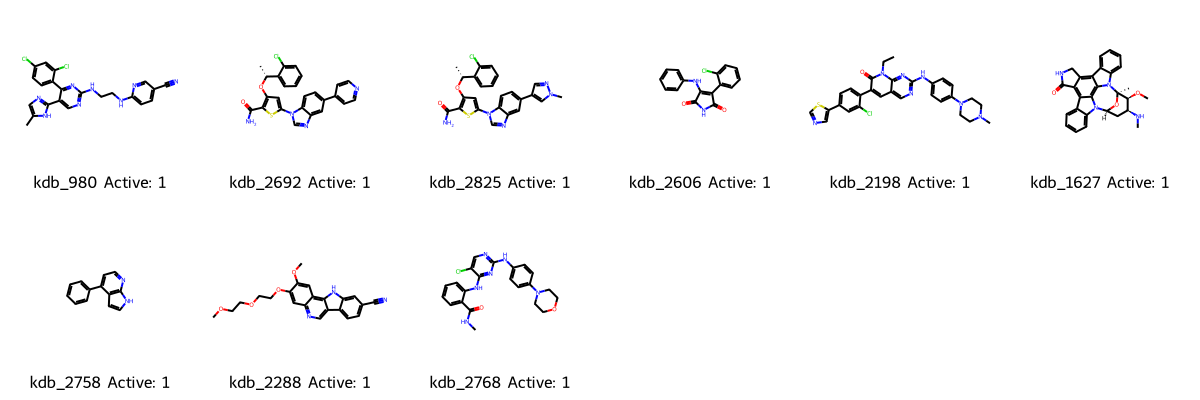

In [161]:
print(f'common false negatives across RF models: {list[271, 272, 273, 274, 276, 278, 279, 280, 281]}')
display_mols(smile_prop_test_idx_reset, list(new_fn))

[275 277]
Common TP[275 277]


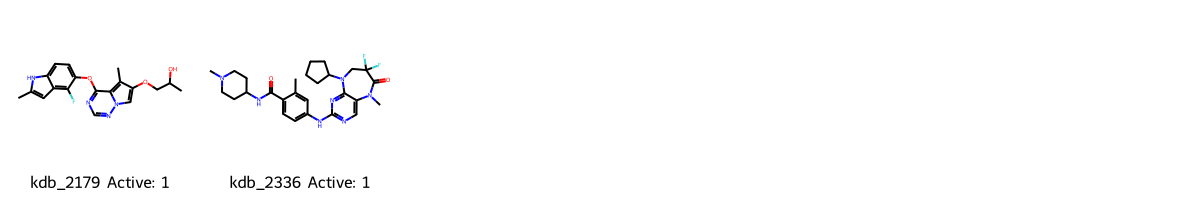

In [162]:
print(og_tp[1])
print(f'Common TP{og_tp[1]}')
display_mols(smile_prop_test_idx_reset, list(og_tp[1]))

test actives: [271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282]


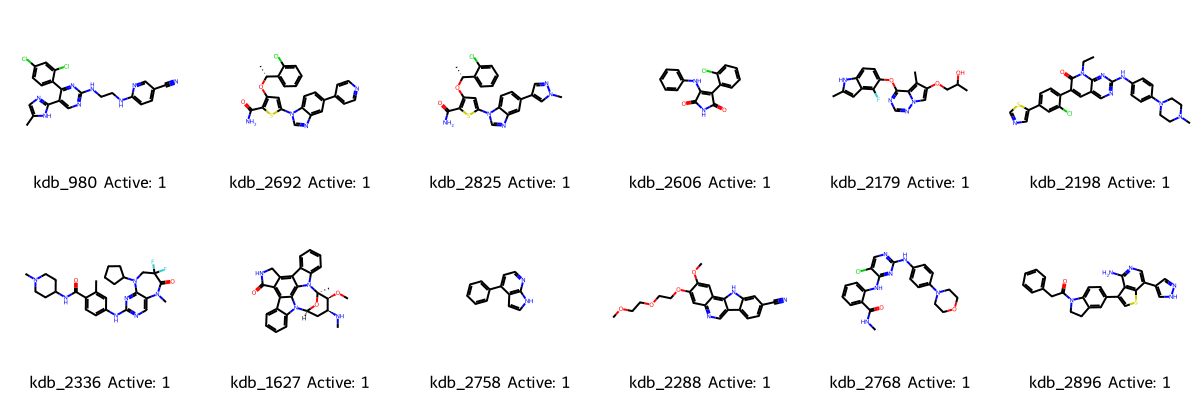

In [163]:
print(f'test actives: {all_active}')
display_mols(smile_prop_test_idx_reset, all_active)

[270 271 272 273 274 275 276 277 278 279 280 281]


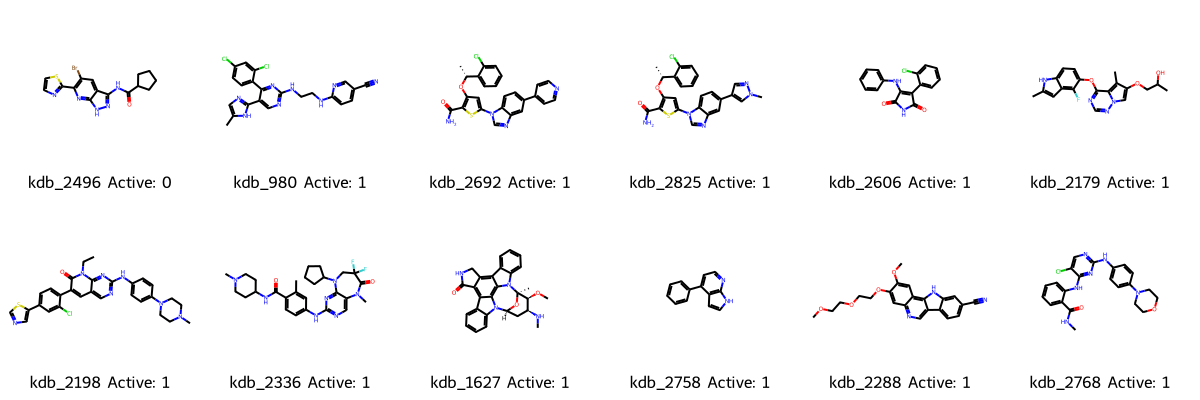

In [164]:
print(og_fn[0])
display_mols(smile_prop_test_idx_reset, list(og_fn[0]))


[270 271 272 273 274 276 278 279 280 281]


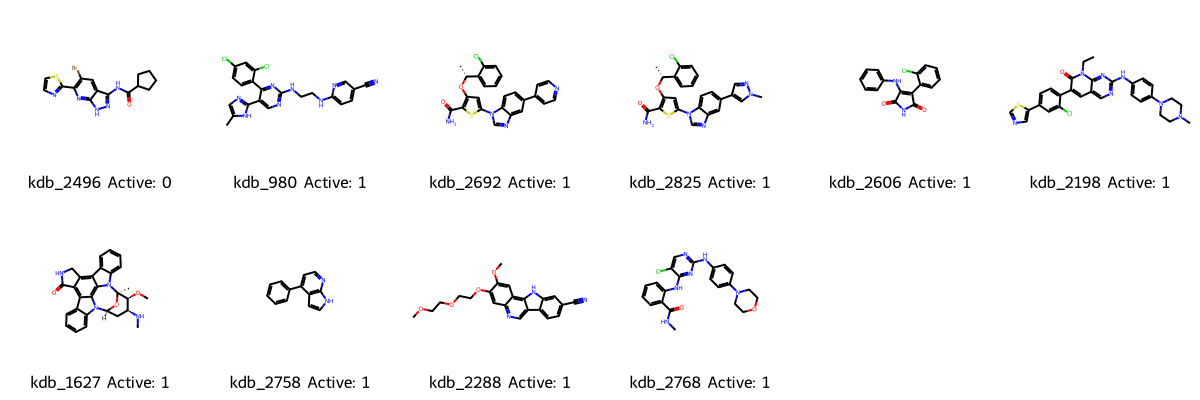

In [165]:
print(og_fn[1])
display_mols(smile_prop_test_idx_reset, list(og_fn[1]))


[270 271 272 273 274 275 276 277 278 279 280 281]


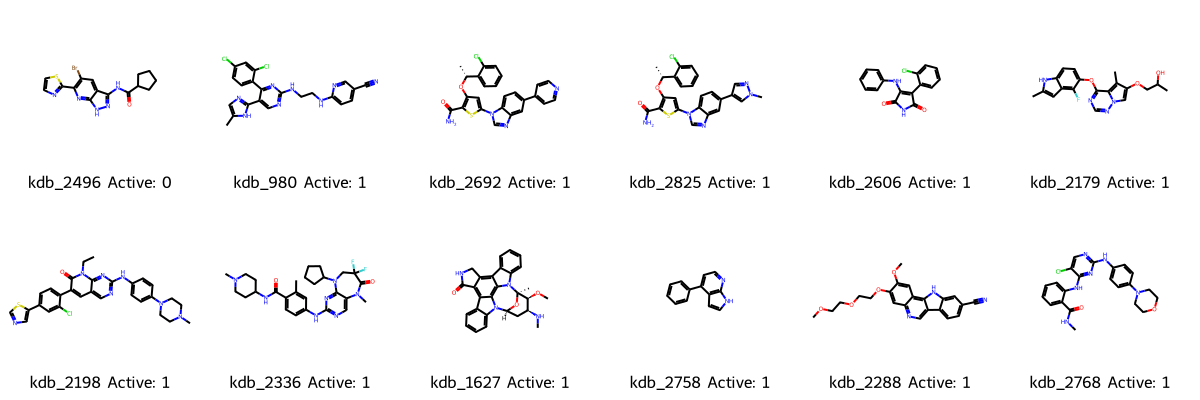

In [166]:
print(og_fn[2])
display_mols(smile_prop_test_idx_reset, list(og_fn[2]))


[270 271 272 273 274 275 276 278 279 280 281]


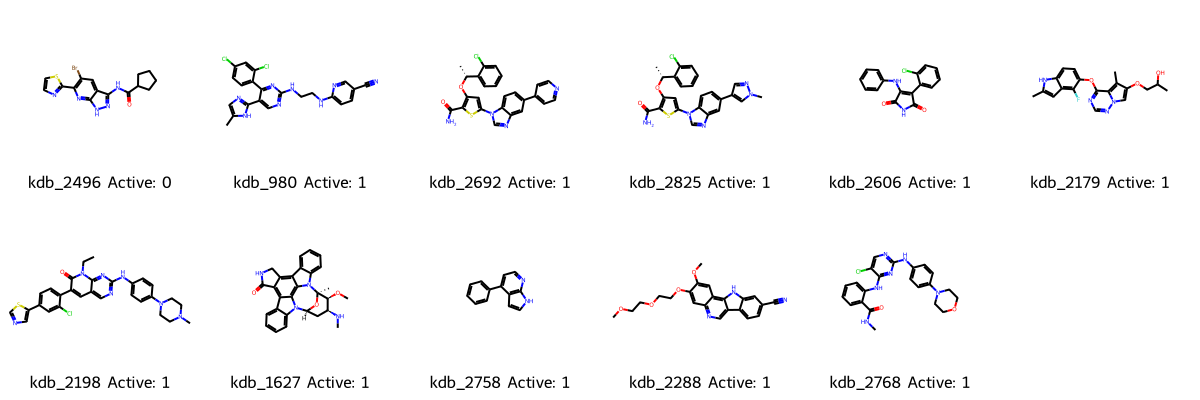

In [167]:
print(og_fn[3])
display_mols(smile_prop_test_idx_reset, list(og_fn[3]))


# FALSE POSITIVES 

where idx:
0 = default, 1 = bal cw, 2 = BRFC, 3 = BRFC + bal cw

[ 10  87 207]


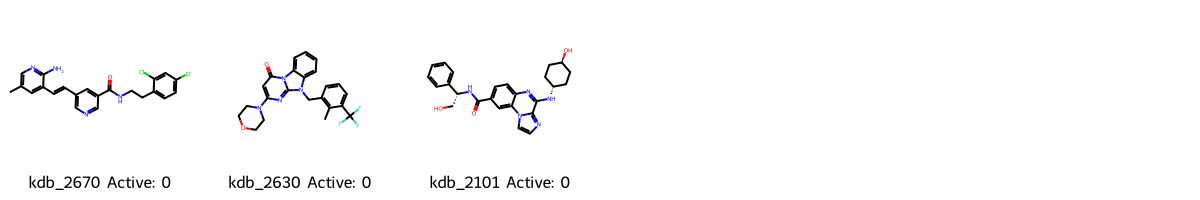

In [168]:
print(og_fp[0])
display_mols(smile_prop_test_idx_reset, list(og_fp[0]))


[  7  24  41  42 144 184 245]


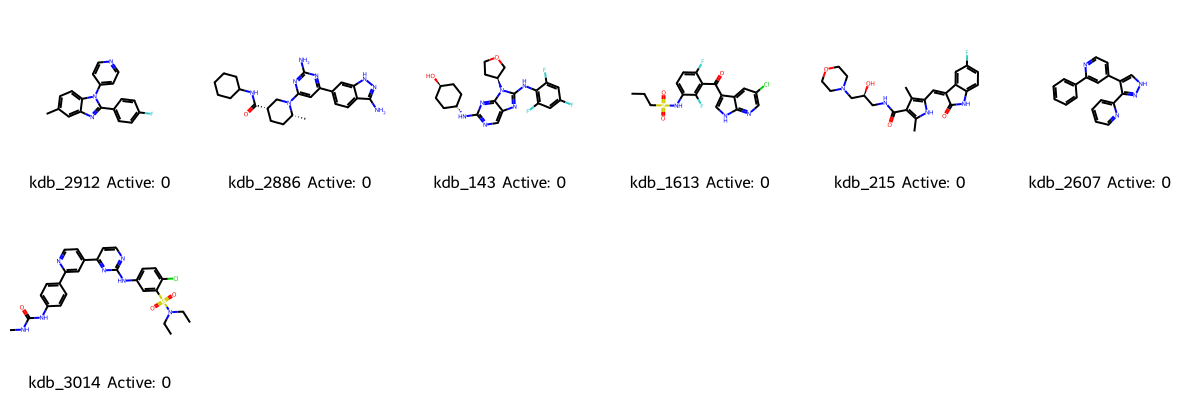

In [169]:
print(og_fp[1])
display_mols(smile_prop_test_idx_reset, list(og_fp[1]))

[ 10  87 207]


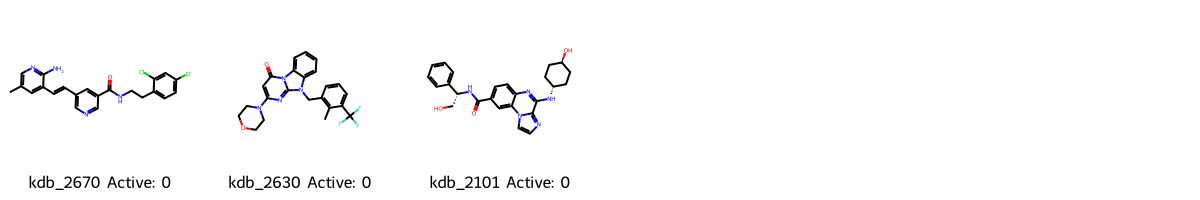

In [170]:
print(og_fp[2])
display_mols(smile_prop_test_idx_reset, list(og_fp[2]))

[  7  24  41 184 245 251]


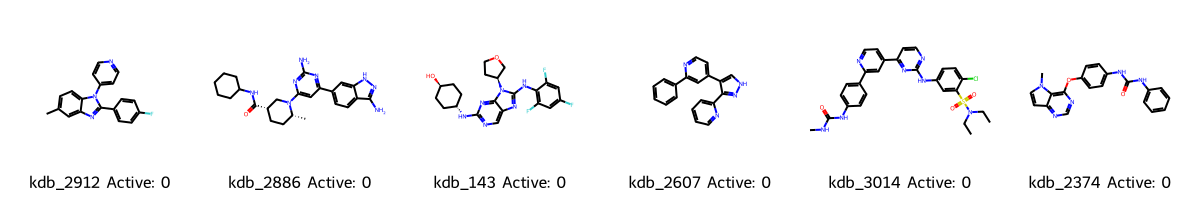

In [171]:
print(og_fp[3])
display_mols(smile_prop_test_idx_reset, list(og_fp[3]))

# True Positives 

In [174]:
# print(og_tp[0])
# display_mols(smile_prop_test_idx_reset, list(og_tp[0]))
# print(og_tp[2])
# display_mols(smile_prop_test_idx_reset, list(og_tp[2]))
# none

[275 277]


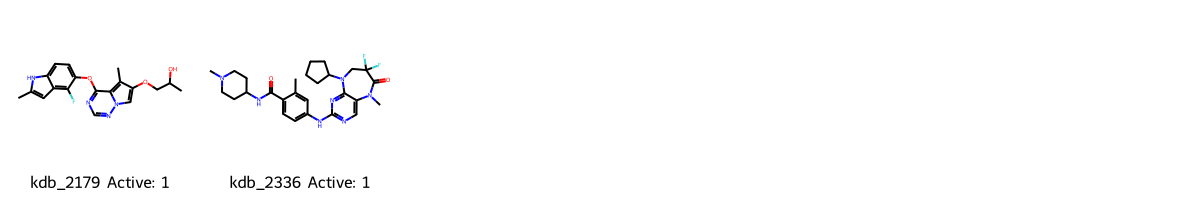

In [175]:
print(og_tp[1])
display_mols(smile_prop_test_idx_reset, list(og_tp[1]))

[277]


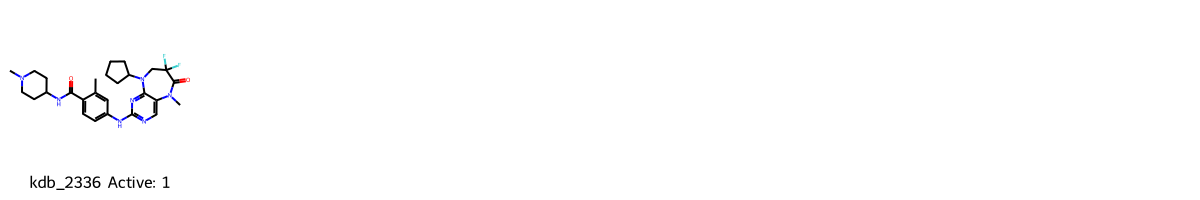

In [177]:
print(og_tp[3])
display_mols(smile_prop_test_idx_reset, list(og_tp[3]))

[  0   1   2   3   4   5   6   7   8   9  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109
 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127
 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145
 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163
 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181
 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199
 200 201 202 203 204 205 206 208 209 210 211 212 213 214 215 216 217 218
 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236
 237 238 239 240 241 242 243 244 245 246 247 248 24

/Users/jayceepang/miniconda3/envs/atom2024/lib/python3.9/site-packages/rdkit/Chem/Draw/IPythonConsole.py:261: UserWarning: Truncating the list of molecules to be displayed to 100. Change the maxMols value to display more.
  warnings.warn(


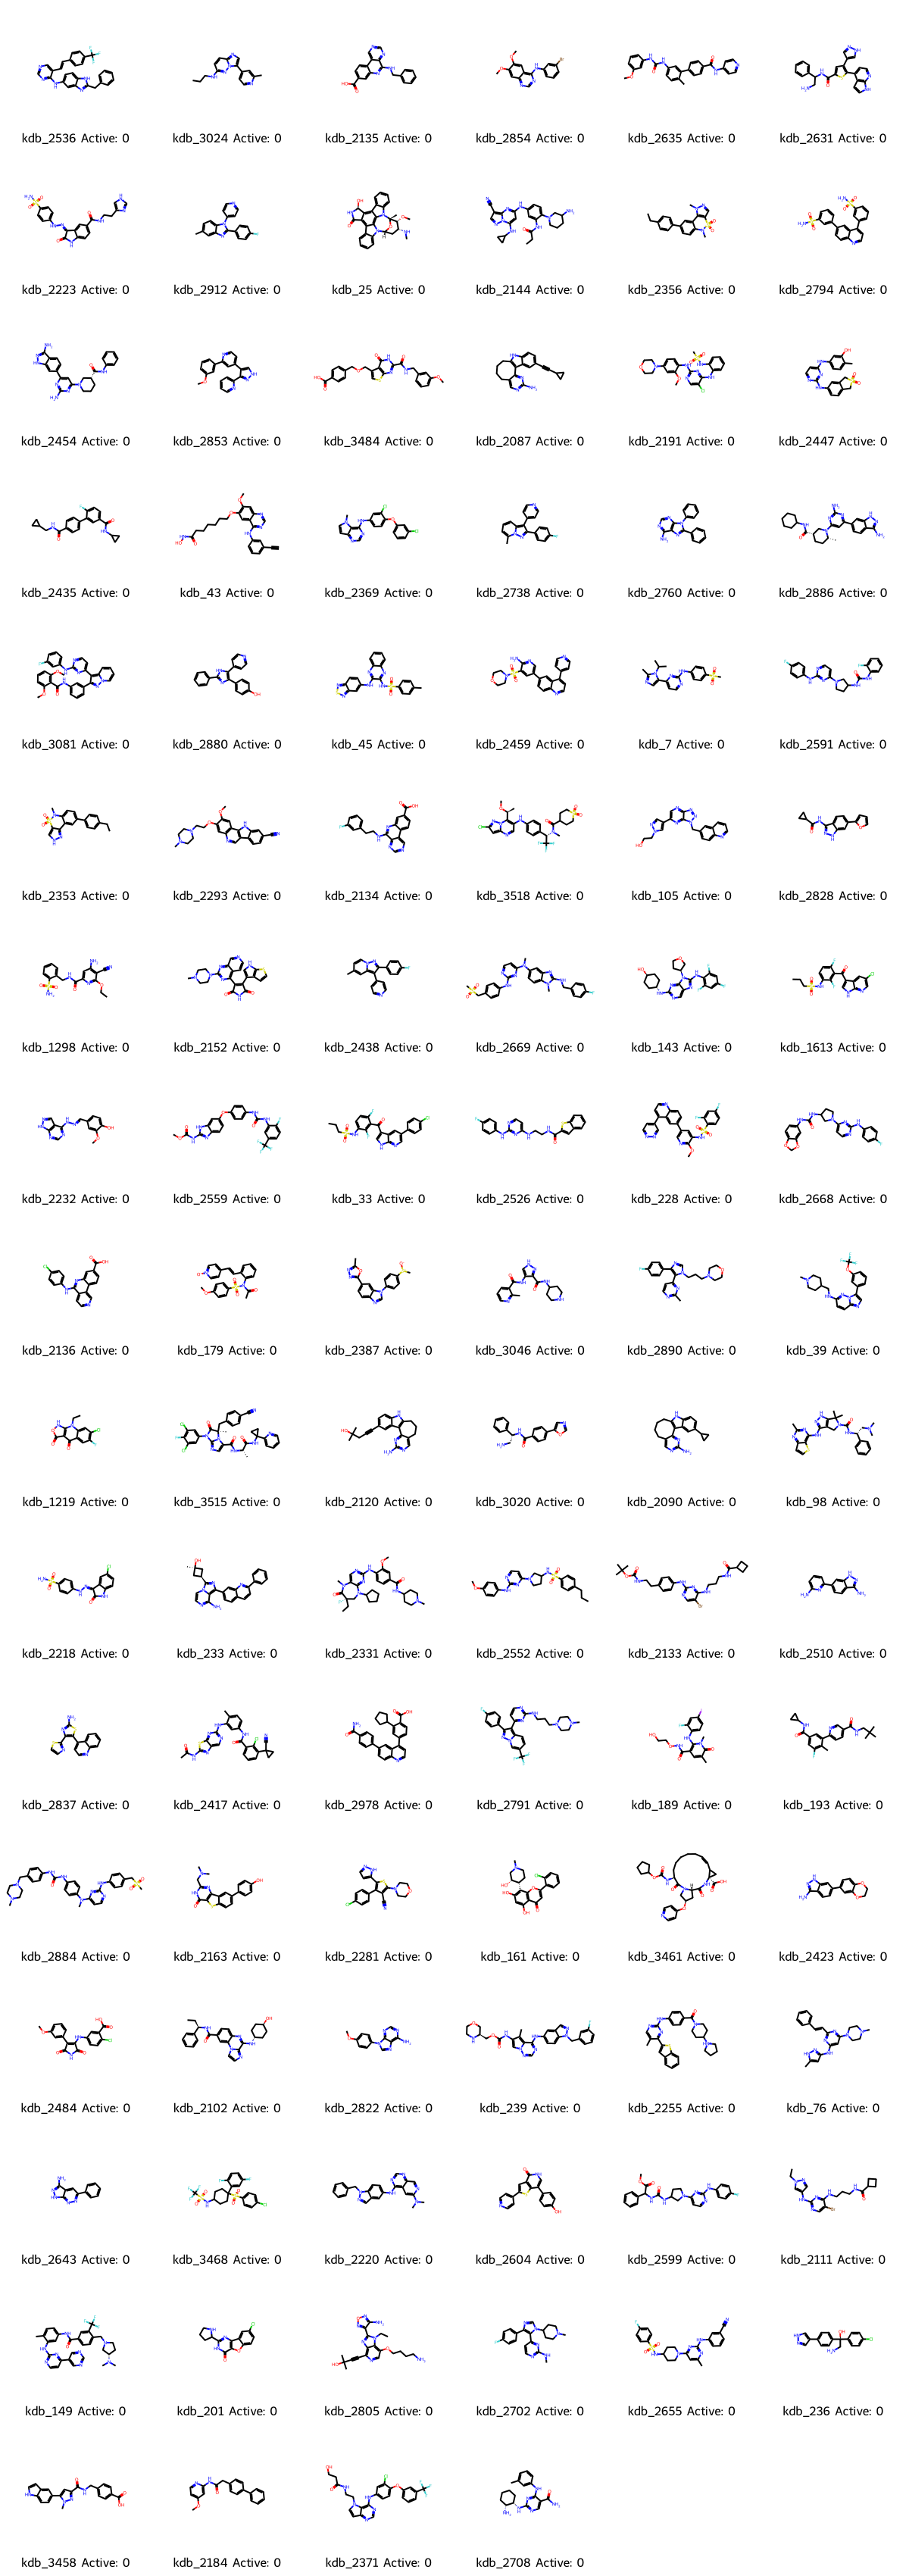

In [172]:
print(og_tn[0])
display_mols(smile_prop_test_idx_reset, list(og_tn[0]))

In [84]:

# smile_prop_df = pd.read_csv('../../../../data/NEK_data_4Berkeley/NEK2/NEK2_1_uM_min_50_pct_binding_5fold_random_imbalanced.csv')

# smile_prop_train = smile_prop_df[smile_prop_df['fold'] != 'fold1'].drop(columns=['fold'])
# smile_prop_test = smile_prop_df[smile_prop_df['fold'] == 'fold1'].drop(columns=['fold'])

# # Diaplaying the active compounds in the training and test set
# mol_train = []
# for i in smile_prop_train.index:
#     print(i)
#     m = Chem.MolFromSmiles(smile_prop_train.loc[i, 'base_rdkit_smiles'])
#     if m:
#         m.SetProp("_Name", smile_prop_train.loc[i, 'compound_id'])
#         m.SetProp("Active", str(smile_prop_train.loc[i, 'active']))
#         mol_train.append(utils.normalize(m))

# mol_test = []
# for i in smile_prop_test.index:
#     m = Chem.MolFromSmiles(smile_prop_test.loc[i, 'base_rdkit_smiles'])
#     if m:
#         m.SetProp("_Name", smile_prop_test.loc[i, 'compound_id'])
#         m.SetProp("Active", str(smile_prop_test.loc[i, 'active']))
#         mol_test.append(utils.normalize(m))
        
# active_train = []

# for m in mol_train:
#     if m.GetProp("Active") == '1':
#         tmp=Chem.AllChem.Compute2DCoords(m)
#         active_train.append(m)

# display(Draw.MolsToGridImage(active_train,molsPerRow=4,subImgSize=(200,200),legends=[x.GetProp("_Name") for x in active_train]))

# active_test = []
# for m in mol_test:
#     if m.GetProp("Active") == '1':
#         tmp=Chem.AllChem.Compute2DCoords(m)
#         active_test.append(m)

# display(Draw.MolsToGridImage(active_test,molsPerRow=4,subImgSize=(200,200),legends=[x.GetProp("_Name") for x in active_test]))


array([275, 277])

None in list


In [19]:
# UNDER 
train_x_df_UNDER = pd.read_csv(bind_split + 'bind_train_x_UNDER.csv', header=None)
train_y_df_UNDER = pd.read_csv(bind_split + 'bind_train_y_UNDER.csv', header=None)
test_y_df_UNDER = pd.read_csv(bind_split + 'bind_test_y_UNDER.csv', header=None)
test_x_df_UNDER = pd.read_csv(bind_split + 'bind_test_x_UNDER.csv', header=None)
train_x_UNDER = train_x_df_UNDER.values
train_y_UNDER = train_y_df_UNDER.values.flatten()
test_y_UNDER= test_y_df_UNDER.values.flatten()
test_x_UNDER = test_x_df_UNDER.values
train_x_UNDER.shape, train_y_UNDER.shape, test_x_UNDER.shape, test_y_UNDER.shape

((90, 306), (90,), (283, 306), (283,))

In [18]:
# SMOTE 
train_x_df_SMOTE = pd.read_csv(bind_split + 'bind_train_x_SMOTE.csv', header=None)
train_y_df_SMOTE = pd.read_csv(bind_split + 'bind_train_y_SMOTE.csv', header=None)
test_y_df_SMOTE = pd.read_csv(bind_split + 'bind_test_y_SMOTE.csv', header=None)
test_x_df_SMOTE = pd.read_csv(bind_split + 'bind_test_x_SMOTE.csv', header=None)
train_x_SMOTE = train_x_df_SMOTE.values
train_y_SMOTE = train_y_df_SMOTE.values.flatten()
test_y_SMOTE= test_y_df_SMOTE.values.flatten()
test_x_SMOTE = test_x_df_SMOTE.values
train_x_SMOTE.shape, train_y_SMOTE.shape, test_x_SMOTE.shape, test_y_SMOTE.shape

((2160, 306), (2160,), (283, 306), (283,))

In [22]:
# ADASYN
train_x_df_ADASYN = pd.read_csv(bind_split + 'bind_train_x_ADASYN.csv', header=None)
train_y_df_ADASYN = pd.read_csv(bind_split + 'bind_train_y_ADASYN.csv', header=None)
test_y_df_ADASYN = pd.read_csv(bind_split + 'bind_test_y_ADASYN.csv', header=None)
test_x_df_ADASYN = pd.read_csv(bind_split + 'bind_test_x_ADASYN.csv', header=None)
train_x_ADASYN = train_x_df_ADASYN.values
train_y_ADASYN = train_y_df_ADASYN.values.flatten()
test_y_ADASYN= test_y_df_ADASYN.values.flatten()
test_x_ADASYN = test_x_df_ADASYN.values
train_x_ADASYN.shape, train_y_ADASYN.shape, test_x_ADASYN.shape, test_y_ADASYN.shape

((2158, 306), (2158,), (283, 306), (283,))